In [408]:
import torch 
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os

torch.manual_seed(42)

In [409]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1. Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current 
year. Prices are in nominal dollars. The task is to predict the price of natural gas using LSTM model 
for the dataset  

    https://datahub.io/core/natural-gas#resource-daily  or  
    https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices 

    Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict 
    the price for the 11th day. 

In [410]:
df=pd.read_csv('daily.csv')
df=df.dropna()
df

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00
...,...,...
7084,2025-03-18,4.17
7085,2025-03-19,4.21
7086,2025-03-20,4.23
7087,2025-03-21,3.93


In [411]:
y = df['Price'].values 
x = np.arange(1, len(y), 1)

In [412]:
minm = y.min() 
maxm = y.max() 
y = (y - minm) / (maxm - minm)

In [413]:
sequence_length = 10
X = [] 
Y = [] 
for i in range(len(y) - sequence_length): 
    l = [] 
    for j in range(i, i + sequence_length): 
        l.append(y[j]) 
    X.append(l) 
    Y.append(y[j + 1])
    
X=np.array(X)
Y=np.array(Y)

In [414]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [415]:
class PriceTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.x.shape[0]
    
train_set = PriceTimeSeries(x_train,y_train)
train_loader = DataLoader(train_set,shuffle=True,batch_size=256)

In [416]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)
        
    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [417]:
model=LSTMModel().to(device)

In [418]:
alpha=0.0001
epochs=200

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=alpha) 

In [419]:
def train(model, epochs, train_loader, criterion, optimizer):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for input, output in train_loader:
            input, output = input.to(device), output.to(device)
            optimizer.zero_grad()
            pred = model(input.view(-1, sequence_length,1))
            loss = criterion(pred, output.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

losses = train(model, epochs, train_loader, criterion, optimizer)

Epoch 1/200, Loss: 0.02593930502948554
Epoch 2/200, Loss: 0.023612064673848774
Epoch 3/200, Loss: 0.02255726273617019
Epoch 4/200, Loss: 0.021148208528757095
Epoch 5/200, Loss: 0.01948797658247792
Epoch 6/200, Loss: 0.019252469560698322
Epoch 7/200, Loss: 0.017896087394784325
Epoch 8/200, Loss: 0.01731908576482016
Epoch 9/200, Loss: 0.01629248225008664
Epoch 10/200, Loss: 0.015960773898531563
Epoch 11/200, Loss: 0.01500041329342386
Epoch 12/200, Loss: 0.014934955326759296
Epoch 13/200, Loss: 0.013989847477363504
Epoch 14/200, Loss: 0.01358968485146761
Epoch 15/200, Loss: 0.01252696472827507
Epoch 16/200, Loss: 0.012550161827517592
Epoch 17/200, Loss: 0.011993673913504766
Epoch 18/200, Loss: 0.011279330042231342
Epoch 19/200, Loss: 0.010849857824328154
Epoch 20/200, Loss: 0.010481554589679708
Epoch 21/200, Loss: 0.010256229434162378
Epoch 22/200, Loss: 0.010075250377311655
Epoch 23/200, Loss: 0.00976434426949076
Epoch 24/200, Loss: 0.009613664557590433
Epoch 25/200, Loss: 0.009277661027

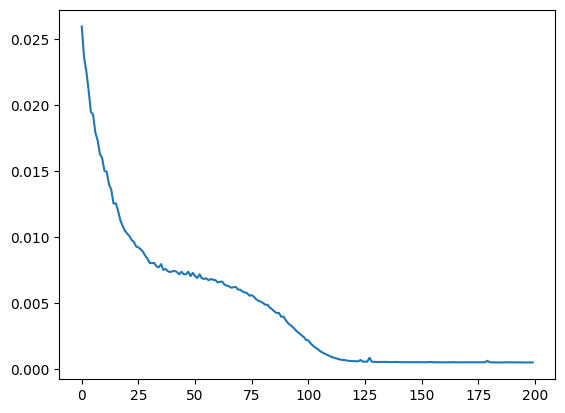

In [420]:
plt.plot(losses)

In [421]:
test_set = PriceTimeSeries(x_train,y_train)
test_loader = DataLoader(test_set,shuffle=False,batch_size=256)

In [422]:
def evaluate(model, test_loader):
    model.eval()
    preds = []
    labels = []
    
    with torch.no_grad():
        for input, output in test_loader:
            input, output = input.to(device), output.to(device)
            pred = model(input.view(-1, sequence_length, 1)).view(-1)
            preds.extend(pred.detach().cpu().numpy())
            labels.extend(output.view(-1).detach().cpu().numpy())
    
    preds=np.array(preds)
    labels=np.array(labels)
    
    return preds, labels

preds,labels = evaluate(model, test_loader)

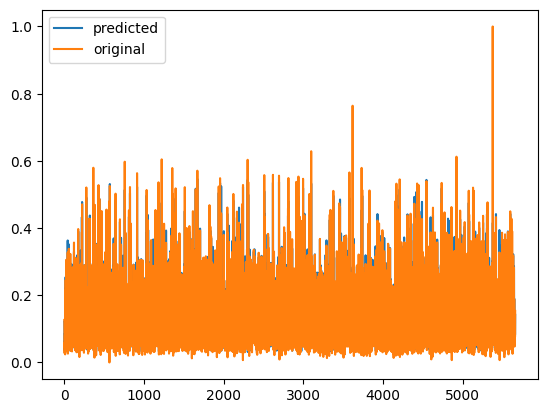

In [423]:
plt.plot(preds,label='predicted')
plt.plot(labels,label='original')
plt.legend()

2. The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a LSTM on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [424]:
data_path='data/names'

names = []
languages = [] 

for filename in os.listdir(data_path):
    lang = filename[:-4]
    file_path = os.path.join(data_path, filename)
    with open(file_path, 'r') as f:
        for line in f:
            names.append(line.strip())  
            languages.append(lang)                      

In [425]:
x_train, x_test, y_train, y_test = train_test_split(names,languages,test_size=0.2,random_state=42)

In [426]:
def prepare_data(names, languages):
    all_chars = set(''.join(names))
    char_to_index = {ch: i+1 for i, ch in enumerate(all_chars)}
    char_to_index['<PAD>'] = 0
    
    language_to_index = {language: i for i, language in enumerate(set(languages))}
    
    max_length = max(len(name) for name in names)
    name_indices = []
    for name in names:
        indices = [char_to_index.get(char, 0) for char in name]
        name_indices.append(indices + [0] * (max_length - len(indices)))
    
    label_indices = [language_to_index[label] for label in languages]
    
    return np.array(name_indices), np.array(label_indices), char_to_index, language_to_index, max_length

x_train_indices, y_train_indices, char_to_index, language_to_index, max_length = prepare_data(x_train, y_train)
x_test_indices, y_test_indices, _, _, _ = prepare_data(x_test, y_test)

In [427]:
class NameLanguageDataset(Dataset):
    def __init__(self, names, labels):
        self.names = torch.tensor(names, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        return self.names[idx], self.labels[idx]
    
train_dataset = NameLanguageDataset(x_train_indices, y_train_indices)
test_dataset = NameLanguageDataset(x_test_indices, y_test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [428]:
class NameLanguageLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(char_to_index), 128)
        self.lstm = nn.LSTM(128, 128, batch_first=True)
        self.fc = nn.Linear(128, len(language_to_index))
    
    def forward(self, x):
        embedded = self.embedding(x)
        out, (h_n, c_n) = self.lstm(embedded)
        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)
        return out

In [429]:
model=NameLanguageLSTM().to(device)

In [430]:
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_data, batch_labels in train_loader:
            batch_data,batch_labels=batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, num_epochs=10)

Epoch 1/10, Loss: 1.8643470579884442
Epoch 2/10, Loss: 1.5658308141734971
Epoch 3/10, Loss: 1.1134916202005638
Epoch 4/10, Loss: 0.859528501313996
Epoch 5/10, Loss: 0.7351745187761299
Epoch 6/10, Loss: 0.6402977885478046
Epoch 7/10, Loss: 0.5779619156364426
Epoch 8/10, Loss: 0.5185269839260208
Epoch 9/10, Loss: 0.4816277190389861
Epoch 10/10, Loss: 0.4393290182152592


In [431]:
def predict(model, name, char_to_index, language_to_index, max_length):
    name_indices = [char_to_index.get(char, 0) for char in name]
    name_indices = name_indices + [0] * (max_length - len(name_indices))
    
    with torch.no_grad():
        model.eval()
        input_tensor = torch.tensor([name_indices], dtype=torch.long).to(device)
        outputs = model(input_tensor)
        predicted_language_index = torch.argmax(outputs, dim=1).item()
        predicted_language = list(language_to_index.keys())[predicted_language_index]
        return predicted_language

In [432]:
test_name = "Smith"
predicted_language = predict(model, test_name, char_to_index, language_to_index, max_length)
print(f"The predicted language for the name '{test_name}' is: {predicted_language}")

The predicted language for the name 'Smith' is: English


3. Implement a next character predictor using LSTM Model

In [433]:
text = "hello world this is a next character prediction example"

chars = sorted(list(set(text)))
char_to_index = {char: idx for idx, char in enumerate(chars)}
index_to_char = {idx: char for idx, char in enumerate(chars)}

seq_length = 40
X = []
y = []

for i in range(len(text) - seq_length):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    X.append([char_to_index[char] for char in seq_in])
    y.append(char_to_index[seq_out])

X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X = X / float(len(chars))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        out = self.softmax(out)
        return out

input_size = 1
hidden_size = 128
output_size = len(chars)
model = LSTMModel(input_size, hidden_size, output_size)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_function(output, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

def predict_next_char(model, input_text, char_to_index, index_to_char, seq_length):
    model.eval()
    input_seq = [char_to_index[char] for char in input_text]
    input_seq = np.array(input_seq)
    input_seq = input_seq.reshape(1, len(input_seq), 1)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)
    input_seq = input_seq / float(len(char_to_index))
    
    with torch.no_grad():
        prediction = model(input_seq)
    predicted_index = torch.argmax(prediction).item()
    return index_to_char[predicted_index]

test_input = "hello wor"
predicted_char = predict_next_char(model, test_input, char_to_index, index_to_char, seq_length)
print(f"Input: '{test_input}' -> Predicted next character: '{predicted_char}'")


Epoch [10/200], Loss: 2.8295
Epoch [20/200], Loss: 2.8021
Epoch [30/200], Loss: 2.7649
Epoch [40/200], Loss: 2.7593
Epoch [50/200], Loss: 2.7503
Epoch [60/200], Loss: 2.7407
Epoch [70/200], Loss: 2.7239
Epoch [80/200], Loss: 2.6970
Epoch [90/200], Loss: 2.6707
Epoch [100/200], Loss: 2.6413
Epoch [110/200], Loss: 2.6172
Epoch [120/200], Loss: 2.5970
Epoch [130/200], Loss: 2.5768
Epoch [140/200], Loss: 2.5584
Epoch [150/200], Loss: 2.5408
Epoch [160/200], Loss: 2.5238
Epoch [170/200], Loss: 2.5076
Epoch [180/200], Loss: 2.4925
Epoch [190/200], Loss: 2.4791
Epoch [200/200], Loss: 2.4685
Input: 'hello wor' -> Predicted next character: 'c'


4. LSTM from scratch on number series 0-20.

In [434]:
def prepare_data(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])
        return out

sequence = np.arange(21)
n_steps = 3
X, y = prepare_data(sequence, n_steps)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

model = LSTMModel(input_size=1, hidden_size=50, num_layers=1, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
test_input = torch.tensor([17, 18, 19], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
with torch.no_grad():
    predicted = model(test_input)
    print(f"Predicted next value: {round(predicted.item())}")


Epoch [50/500], Loss: 7.0221
Epoch [100/500], Loss: 0.0047
Epoch [150/500], Loss: 0.0002
Epoch [200/500], Loss: 0.0041
Epoch [250/500], Loss: 0.0101
Epoch [300/500], Loss: 0.0133
Epoch [350/500], Loss: 0.0006
Epoch [400/500], Loss: 0.0145
Epoch [450/500], Loss: 0.0003
Epoch [500/500], Loss: 0.0021
Predicted next value: 20
